# Load data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, split, size, when
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
spark = SparkSession.builder.appName("CalculatorReviewScore").config("spark.logLevel", "ERROR").getOrCreate()

24/01/22 23:12:59 WARN Utils: Your hostname, TruongHoang resolves to a loopback address: 127.0.1.1; using 192.168.0.109 instead (on interface wlp3s0)
24/01/22 23:12:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/22 23:13:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('review_data_clean.csv', header=True)
df.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: string (nullable = true)
 |-- product_id: string (nullable = true)



In [3]:
print("Number of rows:", df.count())

Number of rows: 121501


In [4]:
df = df.na.drop()
df.show()

+--------------------+--------+----------+
|                text|   label|product_id|
+--------------------+--------+----------+
|được gãy móc khôn...| neutral|   6991111|
|đẹp chắc mượt_khổ...|positive|  73291754|
|đúng chắc_chắn lắ...|positive|  68141773|
|               giống|positive|  55505638|
|chưa_được kỹ bể k...| neutral| 146555381|
|                  êm|positive| 139211455|
|không_giảm lộng k...|positive| 112194231|
|tốt_đẹp ghép phon...|positive| 111635087|
|không_xuất_hóa ti...|negative|  76099465|
|  lâu hư ủng_hộ thêm|positive| 217777834|
|chắc_chắn đúng sớ...|positive|  33893853|
|thường không_phù_...|positive|    453774|
|          ủng_hộ dài|positive| 136021304|
|đẹp chạy nhún_nhả...|positive|  74871299|
|nhanh cẩn_thận dễ ăn|positive|  95035832|
|         gia_đình ok| neutral|  35226708|
|đuọc cài không_đu...|negative| 127010975|
|             đều tốt|positive|  52355000|
|được coi muốn đuô...|negative|    817884|
|   vừa được miễn_phí|positive|   9982809|
+----------

In [5]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, Tokenizer, Word2Vec
from pyspark.ml import Pipeline

# Tiền xử lí

Tiền xử lí thực hiện các công việc sau:
- Tokenizer để chia dòng văn bản thành các từ (tokenize).
- StringIndexer để chuyển đổi cột nhãn (label) từ dạng chuỗi sang dạng số.
- Word2Vec để ánh xạ các từ thành các vector dựa trên ngữ cảnh xuất hiện của chúng trong tập dữ liệu.

In [6]:
def preprocess(df, min_count = 5): 
    # Tokenize the text column
    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    df = tokenizer.transform(df)
    
    # Convert label to numeric
    df = df.withColumn("indexed_label", when(df["label"] == "negative", 0)
                                  .when(df["label"] == "neutral", 1)
                                  .when(df["label"] == "positive", 2))
    
    # Apply Word2Vec on the tokenized words
    word2vec = Word2Vec(vectorSize=100, minCount=min_count, inputCol="words", outputCol="features")
    model = word2vec.fit(df)
    df = model.transform(df)
    
    return df
df = preprocess(df)

## Lấy mẫu 

Do sữ liệu có sự phân bố không đều nên lấy mẫu theo phương pháp lấy mẫu phân tầng

In [7]:
fractions = {"negative": 1, "neutral": 0.6, "positive": 0.2}
train_data = df.sampleBy("label", fractions, seed=42)
test_data = df.subtract(train_data)

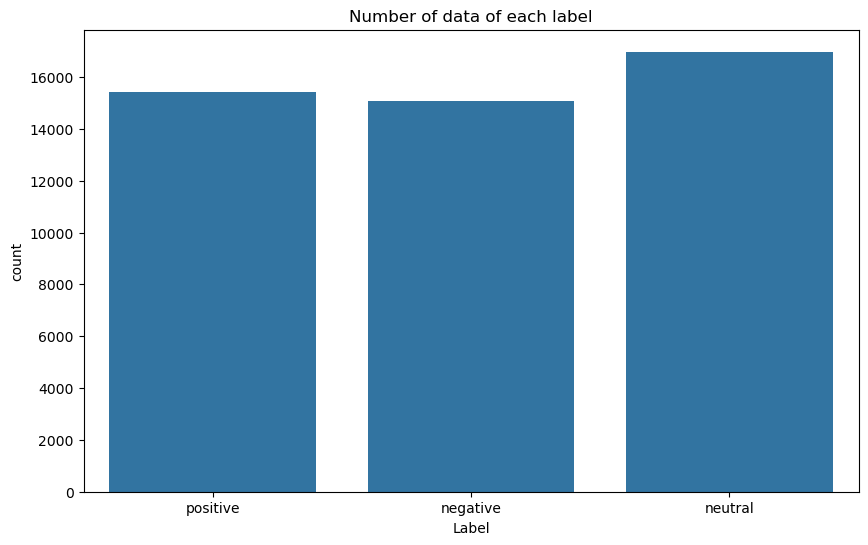

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df_label_to_pd = train_data.select("label").toPandas()
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df_label_to_pd)
plt.xlabel("Label")
plt.title("Number of data of each label")
plt.show()

# Huấn luyện mô hình

In [9]:
import time
training_times = []
prediction_times = []

## Cây quyết định

Cây quyết định là một thuật toán học máy được sử dụng cho các bài toán phân loại và dự đoán. Nó hoạt động bằng cách tạo ra một cấu trúc cây, mỗi nút của cây đại diện cho một quyết định dựa trên một đặc trưng của dữ liệu.

In [10]:
from pyspark.ml.classification import DecisionTreeClassifier
import time

start_training_time = time.time()
dt = DecisionTreeClassifier(labelCol="indexed_label", featuresCol="features")
dt_model = dt.fit(train_data)
end_training_time = time.time()
training_times.append(end_training_time - start_training_time)


start_prediction_time = time.time()
dt_predictions = dt_model.transform(test_data)
end_prediction_time = time.time()
prediction_times.append(end_prediction_time - start_prediction_time)


## One-vs-Rest (OneVsRest hoặc One-vs-All)

One-vs-Rest (OneVsRest hoặc One-vs-All) là một chiến lược trong học máy được sử dụng trong bài toán phân loại đa lớp. Trong bài toán phân loại này, có nhiều lớp hoặc nhãn mà mô hình cần phải dự đoán. Chiến lược One-vs-Rest giải quyết vấn đề này bằng cách chuyển đổi nhiệm vụ phân loại đa lớp thành nhiều nhiệm vụ phân loại nhị phân (binary classification).

In [11]:
from pyspark.ml.classification import LinearSVC, OneVsRest

start_training_time = time.time()
ovr = OneVsRest(classifier=LinearSVC(), labelCol="indexed_label", featuresCol="features")
ovr_pipeline = Pipeline(stages=[ovr])
ovr_model = ovr_pipeline.fit(train_data)
end_training_time = time.time()
training_times.append(end_training_time - start_training_time)

start_prediction_time = time.time()
ovr_predictions = ovr_model.transform(test_data)
end_prediction_time = time.time()
prediction_times.append(end_prediction_time - start_prediction_time)

24/01/22 23:14:49 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
24/01/22 23:14:52 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
24/01/22 23:14:55 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


## MultilayerPerceptron

MultilayerPerceptronClassifier là một mô hình học máy thuộc thư viện PySpark MLlib được sử dụng cho các bài toán phân loại. Nó là một mô hình mạng nơ-ron đa tầng (multilayer perceptron) được huấn luyện bằng thuật toán lan truyền ngược (backpropagation)

In [12]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

start_training_time = time.time()
layers = [100, 5, 3]
mpc = MultilayerPerceptronClassifier(layers=layers, labelCol="indexed_label", featuresCol="features")
mpc_pipeline = Pipeline(stages=[mpc])
mpc_model = mpc_pipeline.fit(train_data)
end_training_time = time.time()
training_times.append(end_training_time - start_training_time)

start_prediction_time = time.time()
mpc_predictions = mpc_model.transform(test_data)
end_prediction_time = time.time()
prediction_times.append(end_prediction_time - start_prediction_time)

# Hồi quy logistic

Hồi quy logistic là một mô hình phân loại thường được sử dụng trong học máy để dự đoán xác suất thuộc một lớp cụ thể. Mặc dù có tên là "Hồi quy logistic" nó thực chất là một mô hình phân loại và không phải là mô hình hồi quy (regression) trong ngữ cảnh hồi quy tuyến tính.

In [13]:
from pyspark.ml.classification import LogisticRegression

start_training_time = time.time()
lr = LogisticRegression(labelCol="indexed_label", featuresCol="features", maxIter=10)
lr_pipeline = Pipeline(stages=[lr])
lr_model = lr_pipeline.fit(train_data)
end_training_time = time.time()
training_times.append(end_training_time - start_training_time)

start_prediction_time = time.time()
lr_predictions = lr_model.transform(test_data)
end_prediction_time = time.time()
prediction_times.append(end_prediction_time - start_prediction_time)

## Rừng ngẫu nhiên

Mô hình rừng ngẫu nhiên (Random Forest) là một phương pháp học máy kết hợp (ensemble learning) được sử dụng để phân loại, hồi quy và các nhiệm vụ khác. Mô hình này được xây dựng bằng cách tạo ra nhiều cây quyết định (decision tree) và sau đó sử dụng kết quả của các cây này để đưa ra dự đoán.

In [14]:
from pyspark.ml.classification import RandomForestClassifier

start_training_time = time.time()
rf = RandomForestClassifier(labelCol="indexed_label", featuresCol="features", numTrees=10)
rf_pipeline = Pipeline(stages=[rf])
rf_model = rf_pipeline.fit(train_data)
end_training_time = time.time()
training_times.append(end_training_time - start_training_time)

start_prediction_time = time.time()
rf_predictions = rf_model.transform(test_data)
end_prediction_time = time.time()
prediction_times.append(end_prediction_time - start_prediction_time)

In [15]:
print(training_times, prediction_times)

[7.59309983253479, 153.5069990158081, 9.346104383468628, 4.813153505325317, 4.031355857849121] [0.1297459602355957, 0.7584941387176514, 0.07294273376464844, 0.03686189651489258, 0.03597569465637207]


## Đánh giá mô hình

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Đánh giá precision, recall, và F1-score cho từng mô hình
def evaluate_model(predictions, model_name):
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="weightedPrecision")
    precision = evaluator.evaluate(predictions)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="weightedRecall")
    recall = evaluator.evaluate(predictions)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="f1")
    f1_score = evaluator.evaluate(predictions)
    
    print(f"{model_name} Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1_score:.4f}")
    print()

# Đánh giá các mô hình
evaluate_model(dt_predictions, "Decision Tree")
evaluate_model(ovr_predictions, "OneVsRest")
evaluate_model(mpc_predictions, "MultilayerPerceptronClassifier")
evaluate_model(lr_predictions, "Logistic Regression")
evaluate_model(rf_predictions, "Random Forest")

# Biểu đồ so sánh
models = ['Decision Tree', 'OneVsRest', 'MLP Classifier', 'Logistic Regression', 'Random Forest']
precisions = [0.0, 0.0, 0.0, 0.0, 0.0]
recalls = [0.0, 0.0, 0.0, 0.0, 0.0]
f1_scores = [0.0, 0.0, 0.0, 0.0, 0.0]

# Cập nhật giá trị của precision, recall, và F1-score
for i, model in enumerate([dt_predictions, ovr_predictions, mpc_predictions, lr_predictions, rf_predictions]):
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="weightedPrecision")
    precisions[i] = evaluator.evaluate(model)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="weightedRecall")
    recalls[i] = evaluator.evaluate(model)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="f1")
    f1_scores[i] = evaluator.evaluate(model)

# Vẽ biểu đồ so sánh
import numpy as np
width = 0.2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

models = ['Decision Tree', 'OneVsRest', 'MLP Classifier', 'Logistic Regression', 'Random Forest']
precisions = [0.0, 0.0, 0.0, 0.0, 0.0]
recalls = [0.0, 0.0, 0.0, 0.0, 0.0]
f1_scores = [0.0, 0.0, 0.0, 0.0, 0.0]

for i, model in enumerate([dt_predictions, ovr_predictions, mpc_predictions, lr_predictions, rf_predictions]):
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="weightedPrecision")
    precisions[i] = evaluator.evaluate(model)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="weightedRecall")
    recalls[i] = evaluator.evaluate(model)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="f1")
    f1_scores[i] = evaluator.evaluate(model)

# Plotting metrics
ax1.bar(np.arange(len(models)) - width, precisions, width, label='Precision', color='blue')
ax1.bar(np.arange(len(models)), recalls, width, label='Recall', color='green')
ax1.bar(np.arange(len(models)) + width, f1_scores, width, label='F1-Score', color='orange')

ax1.set_xticks(np.arange(len(models)))
ax1.set_xticklabels(models)
ax1.set_ylim(0, 1)
ax1.set_title('Precision, Recall, and F1-Score of Different Models')
ax1.set_xlabel('Models')
ax1.set_ylabel('Metrics')
ax1.legend()

# Plotting training and prediction times
ax2.bar(np.arange(len(models)) - width/2, training_times, width, label='Training Time', color='purple')
ax2.bar(np.arange(len(models)) + width/2, prediction_times, width, label='Prediction Time', color='brown')

ax2.set_xticks(np.arange(len(models)))
ax2.set_xticklabels(models)
ax2.set_title('Training and Prediction Times of Different Models')
ax2.set_xlabel('Models')
ax2.set_ylabel('Time (seconds)')
ax2.set_ylim(0, 20)
ax2.legend()

plt.tight_layout()
plt.show()

Decision Tree Metrics:
  Precision: 0.8340
  Recall: 0.6541
  F1-Score: 0.7200



OneVsRest Metrics:
  Precision: 0.8473
  Recall: 0.7467
  F1-Score: 0.7932



MultilayerPerceptronClassifier Metrics:
  Precision: 0.8482
  Recall: 0.7257
  F1-Score: 0.7765



Logistic Regression Metrics:
  Precision: 0.8469
  Recall: 0.6782
  F1-Score: 0.7416



Random Forest Metrics:
  Precision: 0.8357
  Recall: 0.6926
  F1-Score: 0.7502



### Nhận xét:
-  Mô hình Multilayer PerceptronClassifier có độ chính xác và recall cao, và F1-Score khá ổn định và có thời gian train và test không quá chênh lệnh với các mô hình khác. Từ đó chọn mô hình này cho tập dữ liệu

# Test

In [ ]:
from pyspark.sql import Row
from pyspark.sql.types import StringType

# Tạo DataFrame mới từ câu comment mới
new_comment = "sai sai tùm_lum đọc ngứa_mắt giống đang lậu á nhạt dần từng không_kiểm_tra ra thất_vọng"
new_label = ""  
new_data = spark.createDataFrame([Row(text=new_comment, label=new_label)], schema=["text", "label"])

# Áp dụng các bước tiền xử lý cho câu comment mới
new_data = preprocess(new_data, 1)

# Dự đoán với Logistic Regression
mpc_prediction_new = mpc_model.transform(new_data).select("prediction").first().prediction
print(f"Logistic Regression Prediction for New Comment '{new_comment}': {mpc_prediction_new}")

if mpc_prediction_new == 0:
    print("Negative")
elif mpc_prediction_new == 1:
    print("Neutral")
elif mpc_prediction_new == 2:
    print("Positive")


## Áp dụng cho tập dữ liệu

In [ ]:
df = mpc_model.transform(df)

In [ ]:
df.select("text","prediction").show()

# Product ranking

## Load dữ liệu

In [ ]:
product = spark.read.csv('product_data_clean.csv', header=True)
product.printSchema()

In [ ]:
product.count()

In [ ]:
df = df.groupBy("product_id").sum("prediction")
df.show()

In [ ]:
product = product.join(df, product.id == df.product_id, "left")

In [ ]:
product = product.withColumnRenamed("sum(prediction)","review")

In [ ]:
from pyspark.sql.types import LongType, IntegerType, FloatType
product = product.withColumn("discount_rate", col("discount_rate").cast(FloatType()))
product = product.withColumn("day_ago_created", col("day_ago_created").cast(IntegerType()))
product = product.withColumn("all_time_quantity_sold", col("all_time_quantity_sold").cast(LongType()))
product = product.withColumn("rating_average", col("rating_average").cast(FloatType()))

In [ ]:
product = product.fillna(0, subset=["review"])
product = product.na.drop(subset=["all_time_quantity_sold"])
product.count()

In [ ]:
product.select("name", "discount_rate", "day_ago_created", "all_time_quantity_sold", "rating_average", "review").show()

## Chuẩn hóa dữ liệu

Chuẩn hóa theo kiểu Min-Max Scaling chuyển đổi giá trị của biến thành một phạm vi cố định [0,1] :

In [ ]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql import functions as F

In [ ]:
feature_col = "all_time_quantity_sold"

# Use VectorAssembler to transform the column into a vector
assembler = VectorAssembler(inputCols=[feature_col], outputCol="features")

# Use MinMaxScaler to normalize the values
scaler = MinMaxScaler(inputCol="features", outputCol="sale")

In [ ]:
pipeline = Pipeline(stages=[assembler, scaler])

# Fit and transform the data
model = pipeline.fit(product)
product = model.transform(product)

In [ ]:
feature_col = "review"

# Use VectorAssembler to transform the column into a vector
assembler = VectorAssembler(inputCols=[feature_col], outputCol="features_review")

# Use MinMaxScaler to normalize the values
scaler = MinMaxScaler(inputCol="features_review", outputCol="review_standardized")

In [ ]:
pipeline = Pipeline(stages=[assembler, scaler])

# Fit and transform the data
model = pipeline.fit(product)
product = model.transform(product)

In [ ]:
product.printSchema()

In [ ]:
# Extract the normalized value from the 'sale' vector
extract_value_udf = F.udf(lambda v: float(Vectors.dense(v).toArray()[0]), FloatType())
product = product.withColumn("sale", extract_value_udf(col("sale")))

In [ ]:
product = product.withColumn("review_standardized", extract_value_udf(col("review_standardized")))

In [ ]:
product.printSchema()

In [ ]:
from pyspark.sql.functions import expr
product = product.withColumn(
    "score",
    expr("""
        CASE WHEN (1 - day_ago_created / 30) > 0
        THEN (1 - day_ago_created / 30) * 0.4 +
             sale * 0.3 +
             discount_rate / 100 * 0.05 +
             rating_average / 5 * 0.05 +
             review_standardized * 0.2
        ELSE sale * 0.3 +
             discount_rate / 100 * 0.05 +
             rating_average / 5 * 0.05 +
             review_standardized * 0.2
        END
    """)
)


In [ ]:

product.select("name", "discount_rate", "day_ago_created", "all_time_quantity_sold", "rating_average", "review", "score").orderBy(col("score").desc()).show()